### RNA polymerase search with ESM - preliminary analysis

Summary: Generated ESM embeddings for 8 single-subunit RNA polymerases (ssRNAPs), and compared embeddings to ~100,000 phage metagenomic ORFs (downloaded from NCBI virus sequence database), using cosine distance calculations. I also clustered and ran a PCA on the top 1000 hits to the gold-standard T7 ssRNAP. 

### Prerequisites (from ESM github)
- You will need the following modules : tqdm, matplotlib, numpy, pandas, seaborn, scipy, scikit-learn
- Sequence embeddings for phage metagenomic ORFs, obtained with the following batch ESM script:
```
python scripts/extract.py esm2_t33_650M_UR50D data/ncbi-bacteriophage-human-meta.fasta output/ncbi-bacteriophage-human-meta/ --repr_layers 0 32 33 --include mean per_tok
```


In [16]:
import torch
import matplotlib.pyplot as plt
from matplotlib import rcParams
import numpy as np
import pandas as pd
import seaborn as sns

import esm

In [17]:
import scipy
from scipy.spatial.distance import cosine, euclidean
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import DBSCAN
from scipy.cluster.hierarchy import dendrogram
from sklearn.cluster import AgglomerativeClustering

### Add path to embeddings here:


In [552]:
FASTA_PATH = "../data/uniprotkb_2024_02_15.fasta"
BP_FASTA_PATH = "../data/ncbi-bacteriophage-human-meta.fasta"
EMB_PATH = "../output/uniprot_2024_02_15_reprs" # Path to directory of embeddings
BP_EMB_PATH = "../output/ncbi-bacteriophage-human-meta_reprs"
EMB_LAYER = 33

### Load RNAP embeddings

In [553]:
embs, headers = ([], [])
for header, _seq in esm.data.read_fasta(FASTA_PATH):
    fn = f'{EMB_PATH}/{header}.pt' # path to ESM output, per sequence
    emb = torch.load(fn)
    reprs = emb['mean_representations'][EMB_LAYER].numpy()
    embs.append(reprs)
    headers.append(header)

### Load bacteriophage metagenomic ORF embeddings

In [311]:
df_master = pd.read_csv('phage_metagenomic_embeddings.csv', header=None)
df_master = df_master.rename(columns={0: "ID", 1: "desc"})

In [312]:
embeddings = df_master.iloc[:, 2:].to_numpy()
embeddings.shape

(117312, 1280)

## Search ssRNAP embeddings against phage ORFs

### Calculate cosine distances

In [313]:
df_labels = df_master.copy()
for emb, header in zip(embs, headers):
    emb = emb.reshape(1, -1)
    id = header.split("|")[2].split(" ")[0] # Get just the gene ID
    distances = cosine_similarity(emb, embeddings)
    df_labels[id] = distances.reshape(-1, 1)
    df_labels[id] = 1 - df_labels[id]

### Assign labels based on BLAST annotations

In [314]:
df_labels['type'] = np.where(df_labels['desc'].str.contains("DNA-directed RNA poly|DNA directed RNA poly", case=False, regex=True), "DNA dir. RNAP", "other")
df_labels['type'] = np.where(df_labels['desc'].str.contains("RNA dependent|RNA-dependent", case=False, regex=True), "RNA dir. RNAP", df_labels['type'])
df_labels['type'] = np.where(df_labels['desc'].str.contains("DNA poly", case=False), "DNA dir. DNAP", df_labels['type'])

### Plot top 50 ORFs for each ssRNAP

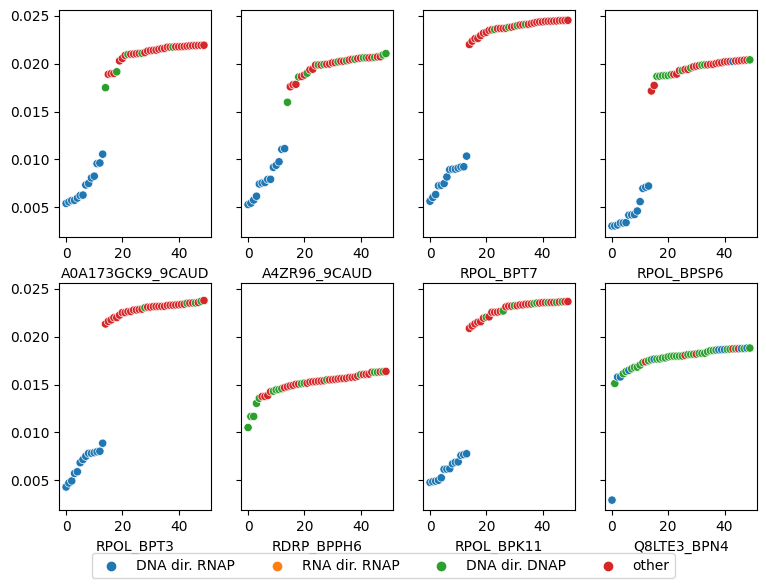

In [9]:
ids = list(df_labels.columns)[-9:-1]
from math import floor
hue_order = ["DNA dir. RNAP", "RNA dir. RNAP", "DNA dir. DNAP", "other"]

fig, ax = plt.subplots(2,4, sharey=True, figsize=(9,6.5))
for i in range(8):
    df_sorted = df_labels.sort_values(ids[i]).iloc[:50].reset_index(drop=True).reset_index()
    g = sns.scatterplot(data=df_sorted, y=ids[i], x="index", hue="type", hue_order=hue_order, ax=ax[floor(i/4)][i%4])
    g.get_legend().remove()
    g.set_ylabel("")
    g.set_xlabel(ids[i])

handles, labels = plt.gca().get_legend_handles_labels()
plt.figlegend(handles, labels, loc = 'lower center', ncol=5, labelspacing=0.)    
#ax[0].set_ylabel("rank")
#ax[1].set_ylabel("")
#fig.show()

## Clustering T7 RNAP hits w/ DBSCAN

In [520]:
# take the top 1000 hits
t7_rnap_hits = df_labels.sort_values("RPOL_BPT7").iloc[:1000]
# assign putative T7-like label to top 14 (based on cut-off from previous analysis)
t7_rnap_hits["group"] = np.where((t7_rnap_hits["RPOL_BPT7"] < 0.01), "T7 RNAP-like", "other")

In [521]:
t7_rnap_embs = t7_rnap_hits.iloc[:,2:1282].to_numpy()

In [522]:
grid_search = [0.0001*x for x in range(1, 300, 5)] # for cosine
result = []
cov = []
for param in grid_search:
    groups = DBSCAN(eps=param, min_samples=8, metric="cosine").fit(t7_rnap_embs).labels_
    result.append(len(set(groups)))
    cov.append(1 - (list(groups).count(-1)/1000))

Text(0.5, 0, 'epsilon')

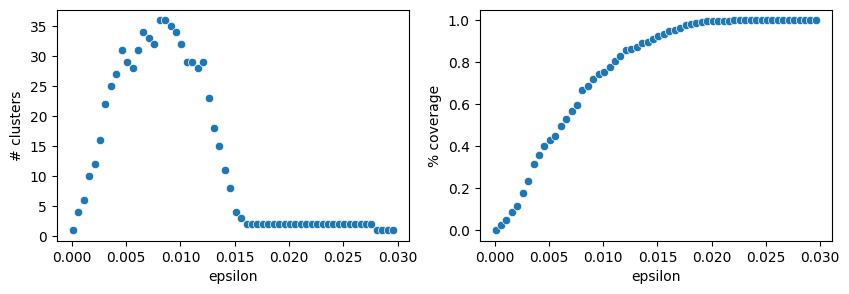

In [524]:
rcParams['figure.figsize'] = [10, 3]
fig, ax = plt.subplots(1,2)
sns.scatterplot(x=grid_search, y=result, ax=ax[0])
sns.scatterplot(x=grid_search, y=cov, ax=ax[1])
ax[0].set_ylabel("# clusters")
ax[1].set_ylabel("% coverage")
ax[0].set_xlabel("epsilon")
ax[1].set_xlabel("epsilon")

In [533]:
# eps 0.01 will give ~30 clusters and ~80% coverage
clustering = DBSCAN(eps=0.01, min_samples=8, metric="cosine").fit(t7_rnap_embs)
t7_rnap_hits["DBSCAN"] = clustering.labels_.tolist()

# write cluster labels to CSV
#t7_rnap_hits.sort_values("DBSCAN").loc[:,["ID", "desc", "DBSCAN"]].to_csv("dbscan.csv")

In [526]:
num_pca_components = 60
pca = PCA(num_pca_components)
pca_fit = pca.fit_transform(t7_rnap_embs)

In [459]:
column_names = [f'PC{i+1}' for i in range(pca_fit.shape[1])]
df_pca = pd.DataFrame(data=pca_fit, columns=column_names)
df_pca["cluster"] = clustering.labels_.tolist()
df_pca["label"] = list(t7_rnap_hits["group"])

/tmp/ipykernel_804532/225950286.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subject["cluster"] = subject['cluster'].astype(str)


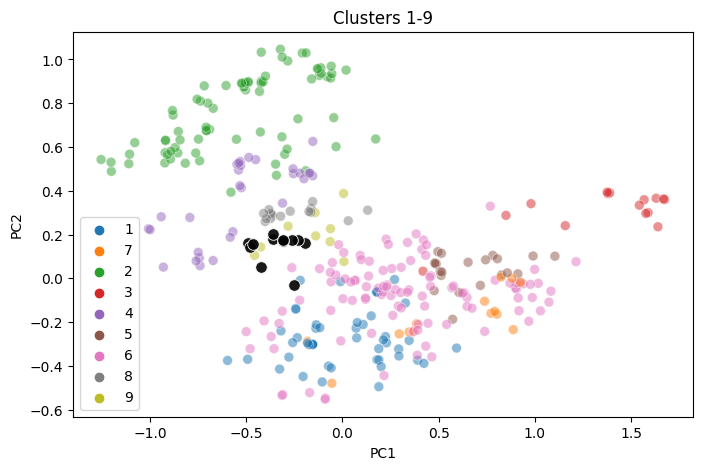

In [541]:
rcParams['figure.figsize'] = [8, 5]

query = df_pca[(df_pca.label != "other")]
subject = df_pca[(df_pca.cluster > 0) & (df_pca.cluster < 10)]
subject["cluster"] = subject['cluster'].astype(str)

PC = "PC2"
#PC = "PC6"
#df_pca["group] = df_pca['group'].astype(str)
g = sns.scatterplot(data=subject, x="PC1", y=PC, hue="cluster", s=50, alpha=0.5)
g = sns.scatterplot(data=query, x="PC1", y=PC, s=70, alpha=0.9, color="black")
plt.title("Clusters 1-9")

legend_handles, _= g.get_legend_handles_labels()
#g.legend(legend_handles, labels, bbox_to_anchor=(1, 1))